### Aakash Thatte
##### Data science and AI, IIT Bhilai (2020-2024)

### Basic data analysis/exploration

In [1]:
%load_ext autoreload
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import umap
from joblib import dump, load
from imblearn.over_sampling import SMOTE, ADASYN
import re
import string 

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [122]:
data = pd.read_excel("./product_reviews.xlsx")
data.head(2)

product  source  \
0  electronics brand product name Tablet A 10.1 T...  Target   
1  electronics brand product name Tablet A 10.1 T...  Target   

                                          categories  \
0  Electronics,iPad & Tablets,All Tablets,XYZ bra...   
1  Electronics,iPad & Tablets,All Tablets,XYZ bra...   

                       date  didPurchase  doRecommend  rating  \
0  2021-01-13T00:00:00.000Z          NaN          1.0     5.0   
1  2021-01-13T00:00:00.000Z          NaN          1.0     5.0   

                                             reviews       title  
0  This product so far has not disappointed. My c...  brand name  
1  great for beginner or experienced person. Boug...   very fast

### Preprocessing and data exploration

In [123]:
import re
import string 

data.drop_duplicates(inplace=True)
data = data[data['date'].notna()]
data = data[data['reviews'].notna()]
data['reviews'] = data['reviews'].str.lower()

table = str.maketrans('', '', string.punctuation)
data['reviews'] = data['reviews'].str.translate(table)
data['reviews'] = data['reviews'].apply(lambda x: re.sub(r'\d+', 'num', str(x)))

# Filling NaN value with 0, so now 0 means not purchased and 1 means purchased
data['didPurchase'].fillna(0, inplace=True)

# adding a new column
data['review_word_count'] = data['reviews'].apply(lambda x: len(str(x).split()))

bad_dates = [28974,29072,29259,29297,29379,29435,29501,29513]

# NaT at bad_dates indexes
data['date'] = pd.to_datetime(data['date'], errors='coerce', yearfirst=True)
data['year'] = data['date'].apply(lambda x: x.year)
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)

# We will now create a hypothesized label, based on the hypothesis
# that rating < 4 has a negative review
data['hypothesis_label'] = data['rating'].map(lambda x: 'positive' if x>=4 else 'negative')

In [124]:
data.to_csv("./preprocessed_reviews.csv")

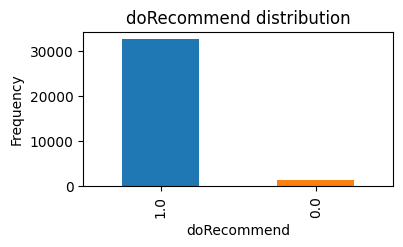

In [7]:
fig = plt.figure(figsize=(4,2))
data['doRecommend'].value_counts().plot(kind='bar', color=['C0', 'C1'])
plt.xlabel("doRecommend")
plt.ylabel("Frequency")
plt.title("doRecommend distribution");

# We can use this distribution to compare the distribution of 
# review sentiment. The sentiment distribution should approximately
# resemble this distribution, because if you feel a product is goood,
# there is more chance that you recommend it.

In [5]:
# Check if something is not recommended (doRecommend=0) but rating>=4
# or if something is recommened but has bad rating(<4)

# This is something that can be considered as an error in collecting data maybe
# Or maybe someone wrongfully recommending a bad product
no_recommend_good_rating = len(data[(data['doRecommend']==0) & (data['rating']>=4)])
recommend_bad_rating = len(data[(data['doRecommend']==1) & (data['rating']<4)])
print(f"Number of products which were not recommended but had good rating - {no_recommend_good_rating}")
print(f"Number of products which were recommended but had bad rating - {recommend_bad_rating}")

Number of products which were not recommended but had good rating - 197
Number of products which were recommended but had bad rating - 1021


In [17]:
fig = px.bar(data_frame=data['doRecommend'].value_counts().rename_axis('doRecommend').reset_index(name='counts'), 
             x='doRecommend',
             y='counts',
             color='doRecommend',
             title="doRecommend frequency distribution", width=700, height=400)
fig.show()

# We can use this distribution to compare the distribution of 
# review sentiment. The sentiment distribution should approximately
# resemble this distribution, because if you feel a product is goood,
# there is more chance that you recommend it.

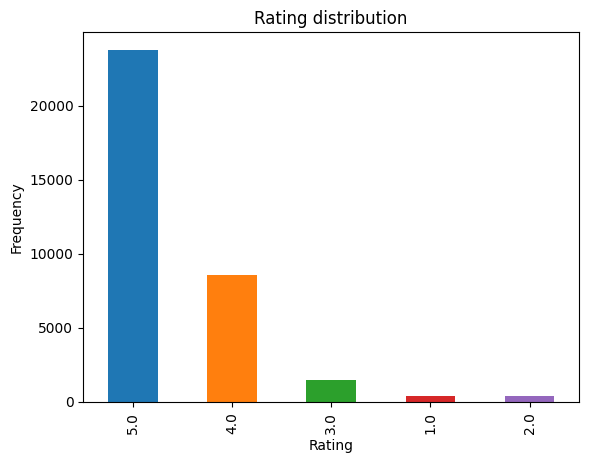

In [8]:
data['rating'].value_counts().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4'])
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Rating distribution");

# We can also use this distribution to compare sentiment distribution
# We can see here that the ratings 1, 2, 3 are quite low, so we expect
# that most of the reviews are positive

In [16]:
fig = px.bar(data_frame=data['rating'].value_counts().rename_axis('rating').reset_index(name='counts'), 
             x='rating',
             y='counts',
             color='rating',
             title="Ratings frequency distribution", width=700, height=400)
fig.show()

<BarContainer object of 2 artists>

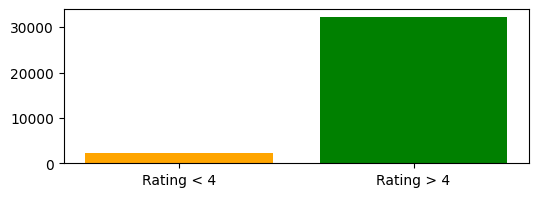

In [20]:
fig = plt.figure(figsize=(6,2))
gt4 = len(data[data['rating']>=4.0])
lt4 = len(data[data['rating']<4.0])
plt.bar(x=["Rating < 4", "Rating > 4"], height=[lt4, gt4], color=['orange', 'green'])

# As we can see, mostly the ratings are on a higher side

In [24]:
# Now we have an imbalanced dataset with 16:1 (positive:negative) ratio
data['hypothesis_label'].value_counts()

positive    32316
negative     2344
Name: hypothesis_label, dtype: int64

In [30]:
# We can see here that negative reviews tend to have
# greater length than positive ones, based on our hypothesis.
# So, we can take this into account
fig = px.box(data_frame=data, x='rating', y='review_word_count', color='hypothesis_label', title="Word count distribution by Rating")
fig.update_layout(yaxis_range=[0,200])
fig.show()

In [27]:
fig = px.histogram(data_frame=data, x='review_word_count', 
                   title="Review length distribution", 
                   color='hypothesis_label', barmode='overlay')
fig.update_xaxes(range=[0,100])
# fig.update_yaxes(range=[0, 10])
fig.add_vline(x=data[data['hypothesis_label']=='positive']['review_word_count'].mean(), 
              line_color='blue', annotation_text='Mean positive', 
              annotation_textangle = 90)
fig.add_vline(x=data[data['hypothesis_label']=='negative']['review_word_count'].mean(), 
              line_color='red', annotation_text='Mean negative', 
              annotation_textangle = 90)

fig.add_vline(x=data[data['hypothesis_label']=='positive']['review_word_count'].median(), 
              line_color='purple', annotation_text='Median positive', 
              annotation_textangle = 90)
fig.add_vline(x=data[data['hypothesis_label']=='negative']['review_word_count'].median(), 
              line_color='orange', annotation_text="Median negative", 
              annotation_textangle = 90, annotation_position='left')
fig.show()

# Here the vertical lines show the average and median review lengths for positive and negative reviews
#  we can confirm from here that on an average, negative reviews tend to be longer

In [125]:
categorized = data.copy(deep=False)
categorized['categories'] = categorized['categories'].apply(lambda x: x.split(","))
categorized = categorized.explode('categories')

In [9]:
categorized.head(2)

product  source      categories  \
0  electronics brand product name Tablet A 10.1 T...  Target     Electronics   
0  electronics brand product name Tablet A 10.1 T...  Target  iPad & Tablets   

                       date  didPurchase  doRecommend  rating  \
0  2021-01-13T00:00:00.000Z          0.0          1.0     5.0   
0  2021-01-13T00:00:00.000Z          0.0          1.0     5.0   

                                             reviews       title  \
0  this product so far has not disappointed my ch...  brand name   
0  this product so far has not disappointed my ch...  brand name   

   review_word_count hypothesis_label  
0                 27         positive  
0                 27         positive

In [50]:
# Let us plot ratings by category
import os
if os.path.exists("./categorized.csv"):
    categorized = pd.read_csv("./categorized.csv", index_col=[0])
    
def ratings_by_category(category):
    fig = px.pie(data_frame=categorized[categorized['categories']==category], 
                # values='categories', 
                names='rating', 
                title=f'Ratings for {category}', width=300, height=300)
    fig.show()

def sentiment_by_category(category):
    fig = px.pie(data_frame=categorized[categorized['categories']==category], 
                # values='categories', 
                names='hypothesis_label', 
                title=f'Sentiment for {category}', width=300, height=300)
    fig.show()

/tmp/ipykernel_33484/2441495070.py:4: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



In [55]:
categorized['categories'].unique()[:10]

array(['Electronics', 'iPad & Tablets', 'All Tablets',
       'XYZ brand Tablets', 'Tablets', 'Computers & Tablets',
       'eBook Readers', 'brand name E-readers', 'E-Readers & Accessories',
       'E-Readers'], dtype=object)

In [11]:
ratings_by_category("Electronics")

In [126]:
# categorized.to_csv("./categorized.csv")

### Utility

In [35]:
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

def get_classification_report(y_true, y_pred, target_names):

    # calculate classification report, and convert it to DataFrame
    clf_report = classification_report(
        y_true=y_true, y_pred=y_pred, target_names=target_names, output_dict=True
    )
    clf_report_df = pd.DataFrame(data=clf_report)
    clf_report_df = clf_report_df.T
    clf_report_df.drop(columns=["support"], inplace=True)

    measures = clf_report_df.columns.tolist()
    classes = clf_report_df.index.tolist()

    # create plotly annotated heatmap, and update styling
    fig = ff.create_annotated_heatmap(clf_report_df.values, x=measures, y=classes)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        title_text="<i><b>Classification report</b></i>",
        xaxis_title="Measures",
        yaxis_title="Class",
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font={
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    )
    fig.update_xaxes(tickangle=-45)
    fig["data"][0]["showscale"] = True

    return fig

def get_confusion_matrix(y_true, y_pred, labels):

    # claculate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    conf_matrix = np.flipud(conf_matrix)

    # create annotated heat map of the confusion matrix
    fig = ff.create_annotated_heatmap(
        conf_matrix, x=labels.tolist(), y=labels.tolist()[::-1]
    )
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        title_text="<i><b>Confusion matrix</b></i>",
        xaxis_title="Predicted category",
        yaxis_title="Real category",
        plot_bgcolor="rgba(0, 0, 0, 0)",
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font={
            "family": "Courier New, monospace",
            "size": 14,
            # 'color': "#eaeaea"
        },
    )
    fig.update_xaxes(tickangle=-45)
    fig["data"][0]["showscale"] = True

    return fig

### Model tracking

In [16]:
import os
if not os.path.exists("./model_tracking.csv"):
    print("Creating model tracking dataframe")
    models_tracking = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
else:
    models_tracking = pd.read_csv("./model_tracking.csv", index_col=[0])
models_tracking

Model  Accuracy  Precision    Recall  F1-Score
0                MultinomialNB  0.937796   0.924192  0.937796  0.926179
1                   Linear_SVM  0.931564   0.919503  0.931564  0.923818
2                      RBF_SVM  0.933064   0.937548  0.933064  0.901434
3              Random_Forest_3  0.926024   0.899455  0.926024  0.908104
4              Random_Forest_3  0.934103   0.915740  0.934103  0.907857
5              Random_Forest_3  0.932949   0.937447  0.932949  0.901154
6            Random_Forest_100  0.933179   0.937648  0.933179  0.901714
7           Embeddings_rbf_svm  0.937219   0.930598  0.937219  0.912992
8             Linear_SVM_SMOTE  0.890941   0.911210  0.890941  0.900032
9  Linear_SVM_SMOTE_Embeddings  0.802424   0.922804  0.802424  0.846492

### Modelling

In [33]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_labels, test_labels = train_test_split(
    data['reviews'], data['hypothesis_label'], 
    stratify=data['hypothesis_label'],
    random_state=13 # To have consistency while reproducing results
)

In [36]:
def get_vectorized_input(X_train, X_test, vectorizer):
    t = time()
    _X_train = vectorizer.fit_transform(X_train)
    _X_test = vectorizer.transform(X_test)
    duration = time() - t
    print("Time taken to extract features from training and test data : %f seconds" % (duration))
    print("Train - n_samples: %d, n_features: %d" % _X_train.shape)
    print("Test - n_samples: %d, n_features: %d" % _X_test.shape)
    print()
    return _X_train, _X_test

X_train_tf, X_test_tf = get_vectorized_input(X_train=train_reviews, X_test=test_reviews, vectorizer=CountVectorizer())

X_train_tfidf, X_test_tfidf = get_vectorized_input(X_train=train_reviews, X_test=test_reviews, vectorizer=TfidfVectorizer())


Time taken to extract features from training and test data : 0.518209 seconds
Train - n_samples: 25995, n_features: 15404
Test - n_samples: 8665, n_features: 15404

Time taken to extract features from training and test data : 0.538067 seconds
Train - n_samples: 25995, n_features: 15404
Test - n_samples: 8665, n_features: 15404



In [17]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

def fit_sklearn_model(model, x_train, y_train):
    t = time()
    model.fit(x_train, y_train)

    training_time = time() - t
    print("train time: %0.3fs" % training_time)

def test_sklearn_model(model, x_test, y_test, model_name):
    t = time()
    y_pred = model.predict(x_test)

    test_time = time() - t
    print("test time:  %0.3fs" % test_time)

    acc = metrics.accuracy_score(y_test, y_pred)
    pre = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')

    print(pd.DataFrame(data={
        'Model':model_name, 'Accuracy':acc, 'Precision':pre, 'Recall':recall, 'F1-Score':f1
    }, index=[1]))
    print('------------------------------')
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    models_tracking.loc[len(models_tracking)] = {
        'Model':model_name, 'Accuracy':acc, 'Precision':pre, 'Recall':recall, 'F1-Score':f1
    }
    
    RocCurveDisplay.from_estimator(model, x_test, y_test, pos_label='positive')
    plt.title("ROC curve");

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    plt.title("Confusion Matrix");

train time: 0.041s
test time:  0.002s
           Model  Accuracy  Precision    Recall  F1-Score
1  MultinomialNB  0.937796   0.924192  0.937796  0.926179
------------------------------


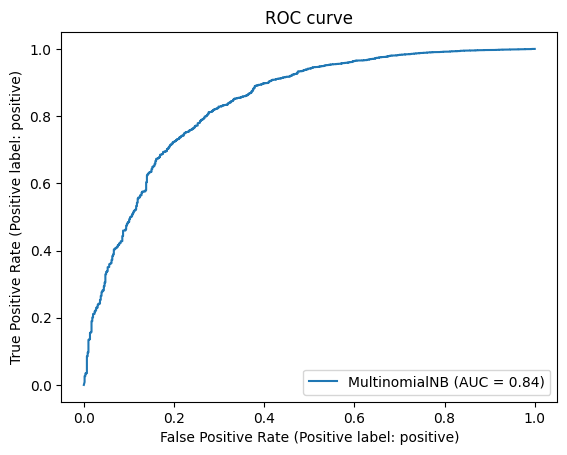

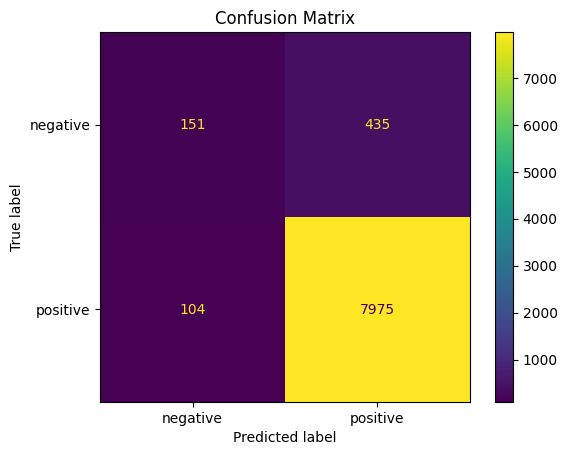

In [80]:
nb = MultinomialNB()
fit_sklearn_model(nb, X_train_tf, train_labels)
test_sklearn_model(nb, X_test_tf, test_labels, model_name="MultinomialNB")

Let us see the misclassifications

In [107]:
misclassified = np.where(test_labels != nb.predict(X_test_tf))

In [111]:
len(test_labels), len(misclassified[0])

(8665, 541)

### Trying SVMs

In [82]:
from sklearn import svm

train time: 127.966s
test time:  6.041s
        Model  Accuracy  Precision    Recall  F1-Score
1  Linear_SVM  0.931564   0.919503  0.931564  0.923818
------------------------------


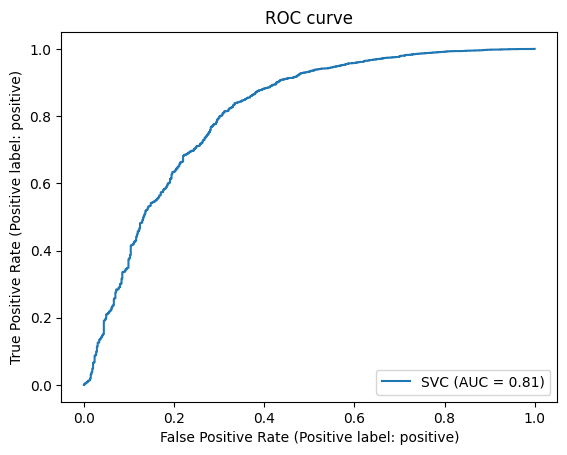

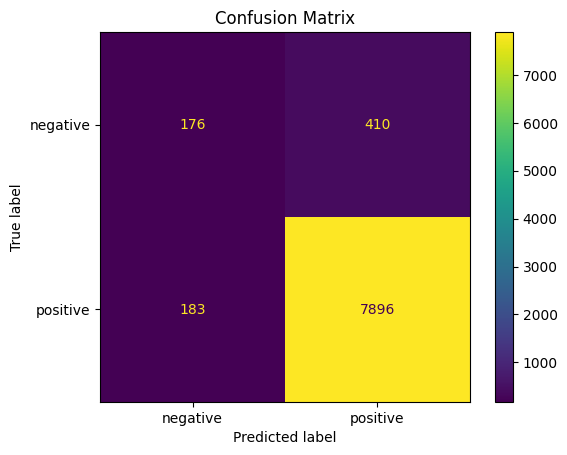

In [84]:
# We could also have used LinearSVC, these are ideally same
# just different implementations internally. LinearSVC is based on liblinear
# and svm.SVC is based on libsvm
linear_svm = svm.SVC(kernel='linear')
fit_sklearn_model(linear_svm, X_train_tf, train_labels)
test_sklearn_model(linear_svm, X_test_tf, test_labels, model_name='Linear_SVM')

train time: 129.417s
test time:  12.992s
     Model  Accuracy  Precision    Recall  F1-Score
1  RBF_SVM  0.933064   0.937548  0.933064  0.901434
------------------------------


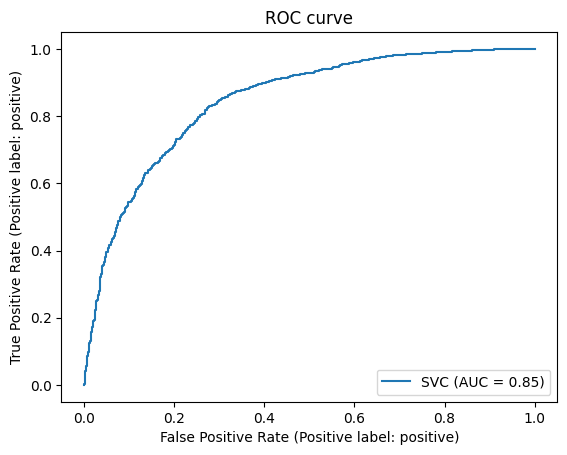

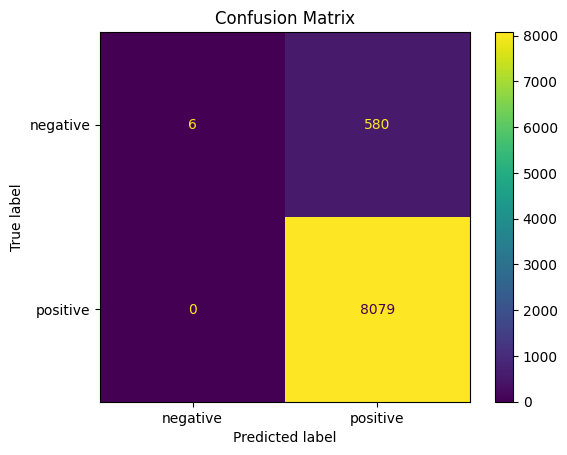

In [86]:
rbf_svm = svm.SVC(kernel='rbf')
fit_sklearn_model(rbf_svm, X_train_tf, train_labels)
test_sklearn_model(rbf_svm, X_test_tf, test_labels, model_name="RBF_SVM")

# As we can see from the confusion matrix, RBF SVM performed badly
# on negative classes, almost wrongly classified all of them

### Ensemble models

In [87]:
from sklearn.ensemble import RandomForestClassifier

train time: 3.995s
test time:  0.087s
               Model  Accuracy  Precision    Recall  F1-Score
1  Random_Forest_100  0.933179   0.937648  0.933179  0.901714
------------------------------


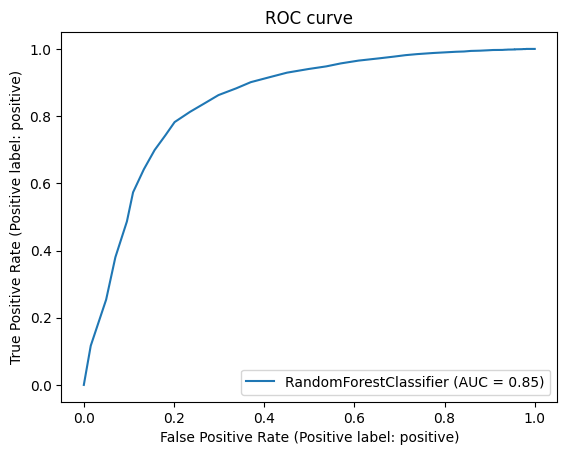

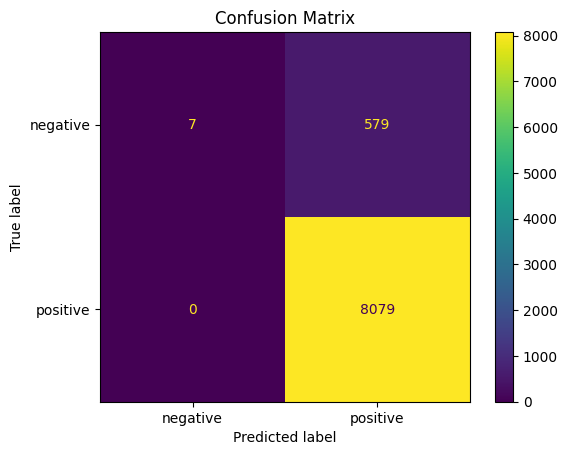

In [96]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', n_jobs=-1)
fit_sklearn_model(rf, X_train_tf, train_labels)
test_sklearn_model(rf, X_test_tf, test_labels, model_name="Random_Forest_100")

# As we can see from the confusion matrix, random forest performed badly
# on negative classes, almost wrongly classified all of them

### Handling class imbalance
We need to do something with the class imbalance, as all of the models we used,
performed good overall but very bad with the negative class.

Method-1 :- Oversampling

In [101]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train_tf, train_labels)
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(X_train_tf, train_labels)

In [102]:
y_resampled_smote.value_counts()

positive    24237
negative    24237
Name: hypothesis_label, dtype: int64

In [22]:
# build naive bayes classification model
t = time()

naive_bayes_classifier_smote = MultinomialNB()
naive_bayes_classifier_smote.fit(X_resampled_smote, y_resampled_smote)

training_time = time() - t
print("train time: %0.3fs" % training_time)

train time: 0.130s


train time: 655.020s
test time:  9.839s
              Model  Accuracy  Precision    Recall  F1-Score
1  Linear_SVM_SMOTE  0.890941    0.91121  0.890941  0.900032
------------------------------


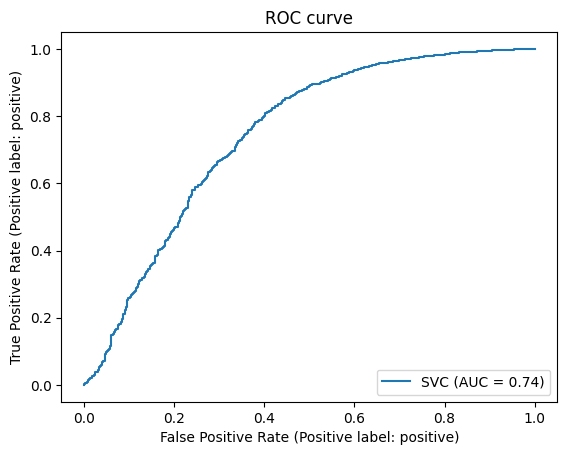

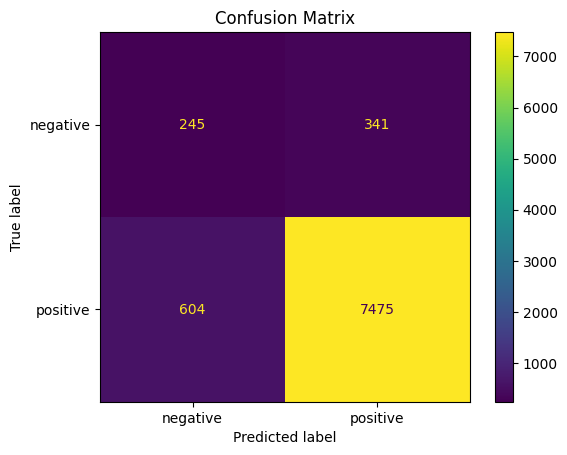

In [103]:
# Because Linear SVM had performed best on negative labels
linear_svm = svm.SVC(kernel='linear')
fit_sklearn_model(linear_svm, X_resampled_smote, y_resampled_smote)
test_sklearn_model(linear_svm, X_test_tf, test_labels, model_name='Linear_SVM_SMOTE')

# Overall numbers are not that good
# But we performed the best on negative classes till now

### Embedding models
I have used `all-miniLM-v6` model from `sentence-transformers` to create review embeddings.
These can then be supplied to downstream models for classification.

#### Create and store embeddings

In [4]:
# I plan to embed every review and store it in LanceDB. Then it can 
# also be queried upon if needed and would remain on disk, we won't need
# to compute everytime.

import lancedb

uri = "data/reviews-embeddings"
db = lancedb.connect(uri)

In [54]:
%load_ext autoreload

In [6]:
%autoreload
from lancedb.embeddings import registry
from lancedb.embeddings.base import TextEmbeddingFunction
from lancedb.embeddings.utils import weak_lru
import sentence_transformers
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings.registry import EmbeddingFunctionRegistry

@registry.register("sentence-transformers")
class SentenceTransformerEmbeddings(TextEmbeddingFunction):
    model_name: str = "all-MiniLM-L6-v2"
    # set more default instance vars like device, etc.

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._ndims = None

    def generate_embeddings(self, texts):
        return self._embedding_model().encode(texts).tolist()

    def ndims(self):
        if self._ndims is None:
            self._ndims = len(self.generate_embeddings(["foo"])[0])
        return self._ndims

    @weak_lru()
    def _embedding_model(self):
        return sentence_transformers.SentenceTransformer(self.model_name)
    

@registry.register("nomic-transformers")
class NomicSentenceEmbeddings(TextEmbeddingFunction):
    model_name: str = "nomic-ai/nomic-embed-text-v1"

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._ndims = None

    def generate_embeddings(self, texts):
        return self._embedding_model().encode(texts, batch_size=8).tolist()

    def ndims(self):
        if self._ndims is None:
            self._ndims = len(self.generate_embeddings(["foo"])[0])
        return self._ndims

    @weak_lru()
    def _embedding_model(self):
        return sentence_transformers.SentenceTransformer(self.model_name, trust_remote_code=True)
    

Tryinh `all-MiniLM-L6-v2` model

In [87]:
registry = EmbeddingFunctionRegistry.get_instance()
stransformer = registry.get("sentence-transformers").create()

In [88]:
class TextModelSchema(LanceModel):
    vector: Vector(stransformer.ndims()) = stransformer.VectorField()
    reviews: str = stransformer.SourceField()

In [97]:
if "all-miniLM-v6" in db.table_names():
    # db.drop_table(name="all-miniLM-v6")
    pass
tbl = db.create_table("all-miniLM-v6", schema=TextModelSchema)

In [98]:
tbl.add(data=pd.DataFrame(data['reviews']))

Trying `nomic-embed-text-v1` model

In [7]:
registry = EmbeddingFunctionRegistry.get_instance()
nomic_transformer = registry.get("nomic-transformers").create()

class NomicModelSchema(LanceModel):
    vector: Vector(nomic_transformer.ndims()) = nomic_transformer.VectorField()
    reviews: str = nomic_transformer.SourceField()

False
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/home/aakash/D/miniconda3/envs/gsoc/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
<All keys matched successfully>


In [8]:
if "nomic-embed-text-v1" in db.table_names():
    # db.drop_table(name="nomic-embed-text-v1")
    pass
tbl = db.create_table("nomic-embed-text-v1", schema=NomicModelSchema)

Inside pydantic.py
Model - <class '__main__.NomicModelSchema'>


In [9]:
# tbl.add(data=pd.DataFrame(data['reviews']))

(1, 768)

In [8]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: NomicBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

#### Load embeddings

In [1]:
import lancedb

uri = "data/reviews-embeddings"
db = lancedb.connect(uri)
tbl = db.open_table("all-miniLM-v6")
reviews_vectors = tbl.to_pandas()

#### Trying sklearn with these embeddings as features

In [99]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
    np.array(reviews_vectors['vector'].values.tolist()), data['hypothesis_label'], 
    stratify=data['hypothesis_label'],
    random_state=13 # To have consistency while reproducing results
)

train time: 122.822s
test time:  17.274s
                Model  Accuracy  Precision    Recall  F1-Score
1  Embeddings_rbf_svm  0.937219   0.930598  0.937219  0.912992
------------------------------


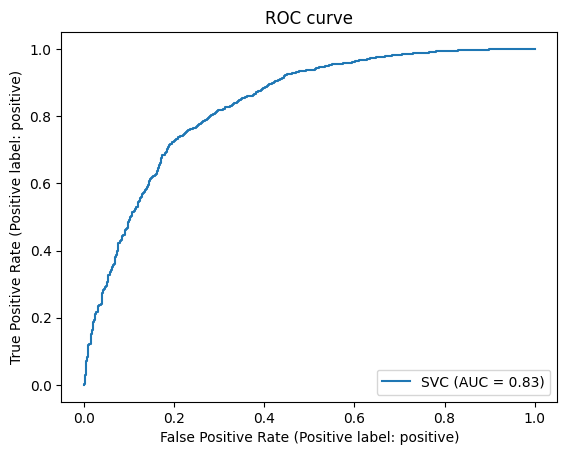

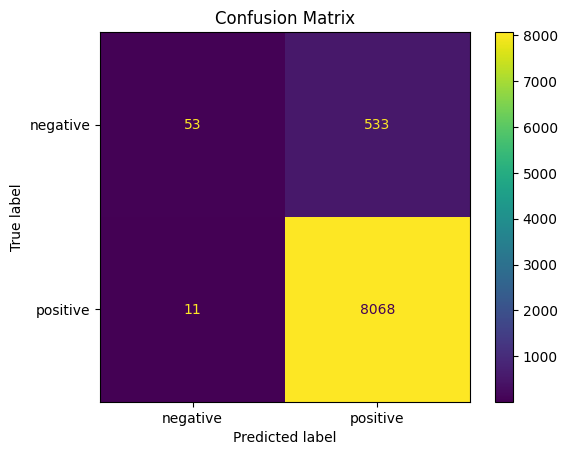

In [100]:
rbf = svm.SVC(kernel='rbf')
fit_sklearn_model(rbf, train_embeddings, train_labels)
test_sklearn_model(rbf, test_embeddings, test_labels, model_name="Embeddings_rbf_svm")

In [104]:
from imblearn.over_sampling import SMOTE
X_resampled_smote_embedding, y_resampled_smote_embedding = SMOTE().fit_resample(train_embeddings, train_labels)

In [ ]:
# Because Linear SVM had performed best on negative labels
linear_svm = svm.SVC(kernel='linear')
fit_sklearn_model(linear_svm, X_resampled_smote_embedding, y_resampled_smote_embedding)

test time:  47.437s
                         Model  Accuracy  Precision    Recall  F1-Score
1  Linear_SVM_SMOTE_Embeddings  0.802424   0.922804  0.802424  0.846492
------------------------------


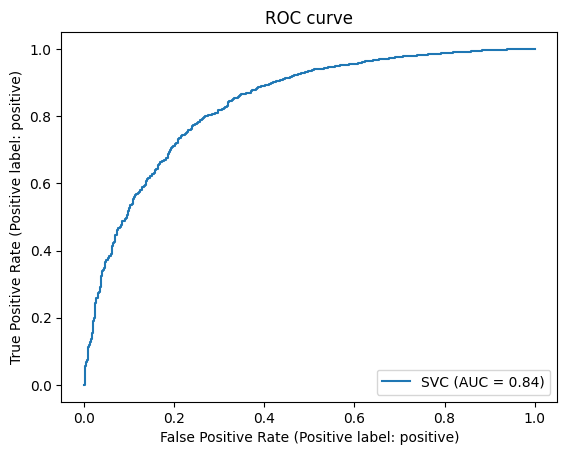

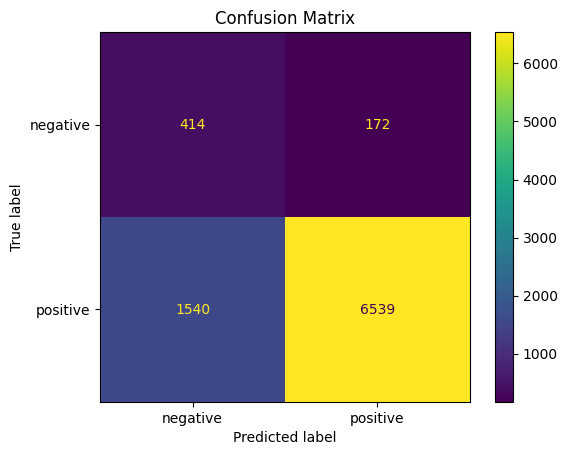

In [106]:
test_sklearn_model(linear_svm, test_embeddings, test_labels, model_name='Linear_SVM_SMOTE_Embeddings')

# We can see that though the overall F1 score is not as good as other models
# But this model has performed very well on the negative classes
# This is due to the oversampling approach used, to give equal representation
# to both classes in the training data

In [107]:
# For this model, let us see the class-wise metrics
print(f"Precision on negative class - {414/(414+1540)}")
print(f"Recall for negative class - {414/(414+172)}")

Precision on negative class - 0.21187308085977483
Recall for negative class - 0.7064846416382252


Using nomic embeddings

In [13]:
import lancedb

uri = "data/reviews-embeddings"
db = lancedb.connect(uri)
tbl = db.open_table("nomic-embed-text-v1")
reviews_vectors = tbl.to_pandas()

In [15]:
train_embeddings_nomic, test_embeddings_nomic, train_labels, test_labels = train_test_split(
    np.array(reviews_vectors['vector'].values.tolist()), data['hypothesis_label'], 
    stratify=data['hypothesis_label'],
    random_state=13 # To have consistency while reproducing results
)
svm_nomic = svm.SVC(kernel='linear')
fit_sklearn_model(svm_nomic, train_embeddings_nomic, train_labels)

train time: 63.701s


test time:  14.152s
                         Model  Accuracy  Precision    Recall  F1-Score
1  Linear_SVM_Nomic_Embeddings  0.950952   0.944593  0.950952  0.944448
------------------------------


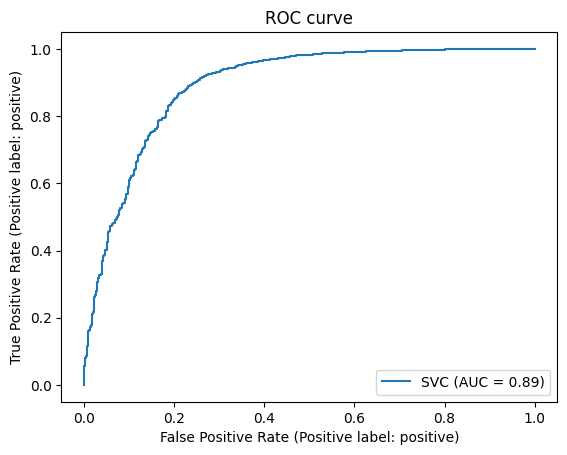

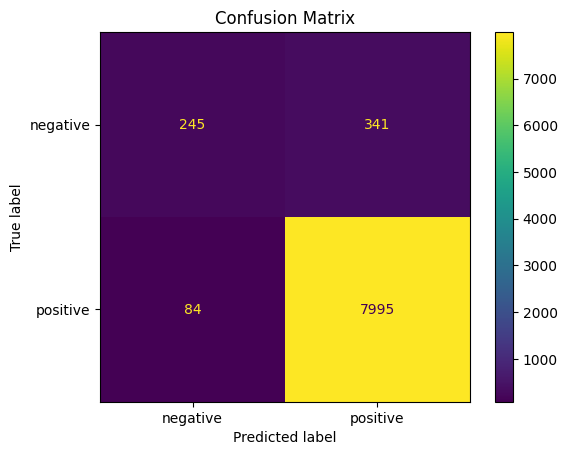

In [18]:
test_sklearn_model(svm_nomic, test_embeddings_nomic, test_labels, model_name="Linear_SVM_Nomic_Embeddings")

In [14]:
from imblearn.over_sampling import SMOTE
train_embeddings_nomic, test_embeddings_nomic, train_labels, test_labels = train_test_split(
    np.array(reviews_vectors['vector'].values.tolist()), data['hypothesis_label'], 
    stratify=data['hypothesis_label'],
    random_state=13 # To have consistency while reproducing results
)
X_resampled_smote_embedding_nomic, y_resampled_smote_embedding_nomic = SMOTE().fit_resample(train_embeddings_nomic, train_labels)

In [18]:
svm_nomic_smote = svm.SVC(kernel='linear')
fit_sklearn_model(svm_nomic_smote, X_resampled_smote_embedding_nomic, y_resampled_smote_embedding_nomic)

train time: 429.522s


test time:  67.057s
                    Model  Accuracy  Precision    Recall  F1-Score
1  Linear_SVM_Nomic_SMOTE  0.895211   0.940239  0.895211  0.911495
------------------------------


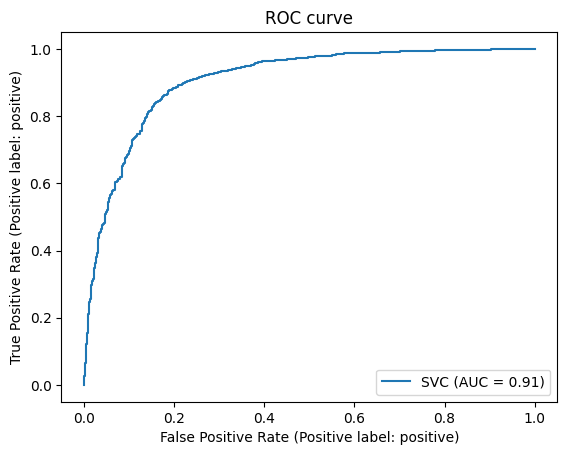

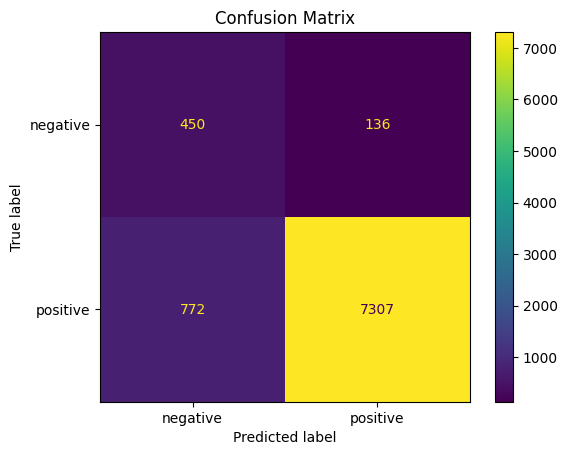

In [19]:
test_sklearn_model(svm_nomic_smote, test_embeddings_nomic, test_labels, model_name="Linear_SVM_Nomic_SMOTE")

In [20]:
# This has been the best model thus far, let me save it
# dump(svm_nomic_smote, filename="./sk_models/svm_linear_nomic_smote.joblib")

['./sk_models/svm_linear_nomic_smote.joblib']

In [35]:
svm_nomic_smote.coef_.shape

(1, 768)

### Classwise performance and model tracking

In [21]:
models_tracking

Model  Accuracy  Precision    Recall  F1-Score
0                 MultinomialNB  0.937796   0.924192  0.937796  0.926179
1                    Linear_SVM  0.931564   0.919503  0.931564  0.923818
2                       RBF_SVM  0.933064   0.937548  0.933064  0.901434
3               Random_Forest_3  0.926024   0.899455  0.926024  0.908104
4               Random_Forest_3  0.934103   0.915740  0.934103  0.907857
5               Random_Forest_3  0.932949   0.937447  0.932949  0.901154
6             Random_Forest_100  0.933179   0.937648  0.933179  0.901714
7            Embeddings_rbf_svm  0.937219   0.930598  0.937219  0.912992
8              Linear_SVM_SMOTE  0.890941   0.911210  0.890941  0.900032
9   Linear_SVM_SMOTE_Embeddings  0.802424   0.922804  0.802424  0.846492
10       Linear_SVM_Nomic_SMOTE  0.895211   0.940239  0.895211  0.911495

In [22]:
# For a few of the models that I experimented with, I will try to create a classwise metrics table
# I will use the confusion matrices for this
class_wise_performance = {
        'Linear_SVM_Nomic_SMOTE':{
            'positive':{
            'Precision': (7307)/(7307+136),
            'Recall': (7307)/(7307+772)
            },
            'negative':{
                'Precision': (450)/(450+772),
                'Recall': (450)/(450+136)
            }
        },
        'Linear_SVM_all-MiniLM-SMOTE':{
            'positive':{
            'Precision': (6539)/(6539+172),
            'Recall': (6539)/(6539+1540)
            },
            'negative':{
                'Precision': (414)/(414+1540),
                'Recall': (414)/(414+172)
            }
        }
}

In [29]:
new_dict = {}
for outerKey, innerDict in class_wise_performance.items():
   for innerKey, values in innerDict.items():
      new_dict[(outerKey, innerKey)] = values
classwise_perf_df = pd.DataFrame(new_dict).transpose()
classwise_perf_df

Precision    Recall
Linear_SVM_Nomic_SMOTE      positive   0.981728  0.904444
                            negative   0.368249  0.767918
Linear_SVM_all-MiniLM-SMOTE positive   0.974370  0.809382
                            negative   0.211873  0.706485

In [30]:
classwise_perf_df.to_csv("./class_wise_perf.csv")

### Embedding visualization

In [6]:
import umap

def get_random_embeddings(size=500, n_components=2):
    np.random.seed(13)
    reducer = umap.UMAP(n_components=n_components)
    # Let us randomly take size indices along with their labels
    idx = np.random.choice(a=list(range(34660)), size=size)
    random_embeddings = np.array(reviews_vectors['vector'][idx].values.tolist())
    random_labels = data['hypothesis_label'][idx].tolist()

    reduced_embeddings = reducer.fit_transform(random_embeddings)
    return reduced_embeddings, random_labels

In [9]:
def plot_embeddings(reduced_embedding, random_labels, three_d=False, interactive=False, title=None):
    d = pd.DataFrame(columns=["x", "y", "label"])
    d['x'] = reduced_embedding[:, 0]
    d['y'] = reduced_embedding[:, 1]
    d['label'] = random_labels
    if three_d:
        d['z'] = reduced_embedding[:, 2]

    if interactive:
        if three_d:
            fig = px.scatter_3d(data_frame=d, x='x', y='y', z='z', color='label', title=title)
        else:
            fig = px.scatter(data_frame=d, x='x', y='y', color='label', title=title)
        fig.show()
    else:
        if three_d:
            raise ValueError("Currently 3D only in interactive mode")
        else:
            sns.scatterplot(d, hue='label', x='x', y='y')
            plt.title(title)

Embeddings generated by `all-MiniLM-L6-v2`

In [12]:
reduced, lalebs = get_random_embeddings(size=30000)
plot_embeddings(reduced_embedding=reduced, random_labels=lalebs, interactive=True, title="All-MiniLM-L6-v2")

In [120]:
reduced_3d, labels_3d = get_random_embeddings(size=5000, n_components=3)
plot_embeddings(reduced_3d, labels_3d, interactive=True, three_d=True)

Embeddings generated by `nomic-embed-text-v1`

In [31]:
nomic_2d_30t, labels_2d_30t = get_random_embeddings(size=30000, n_components=2)
plot_embeddings(nomic_2d_30t, labels_2d_30t, interactive=True, three_d=False)

In [32]:
nomic_3d_15t, labels_3d_15t = get_random_embeddings(size=15000, n_components=3)
plot_embeddings(nomic_3d_15t, labels_3d_15t, interactive=True, three_d=True)

In [119]:
models_tracking.to_csv("./model_tracking.csv")

### Exploring the categorywise products

In [2]:
cat = pd.read_csv("./categorized.csv", index_col=[0])

/tmp/ipykernel_16182/4280863442.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  cat = pd.read_csv("./categorized.csv", index_col=[0])


In [3]:
cat['categories'].unique()

array(['Electronics', 'iPad & Tablets', 'All Tablets',
       'XYZ brand Tablets', 'Tablets', 'Computers & Tablets',
       'eBook Readers', 'brand name E-readers', 'E-Readers & Accessories',
       'E-Readers', 'eBook Readers & Accessories', 'Covers',
       'brand name Store', 'Target Device Accessories',
       'brand name E-Reader Accessories',
       'brand name (5th Generation) Accessories',
       'brand name (5th Generation) Covers', 'Target Devices',
       'Computers', 'Computer Components', 'Hard Drives & Storage',
       'Target Devices & Accessories', 'Power Adapters & Cables',
       'brand name Paperwhite Accessories', 'PocketBook Touch HD 3 Store',
       'PocketBook Touch HD 3 E-Reader Accessories',
       'PocketBook Touch HD 3 Paperwhite Accessories',
       'Computers/Tablets & Networking', 'Tablets & eBook Readers',
       'Used:Computers Accessories', 'Used:Tablets', 'iPads Tablets',
       'Electronics Features', ' Tech Toys', ' Movies', ' Music',
       'Android

In [5]:
c = 'Electronics'

In [15]:
top = cat[(cat['categories']==c) & ((cat['rating']==1) | (cat['rating']==2))]
len(top)

998

In [16]:
pr = top.groupby('product')

In [17]:
df = pd.DataFrame(pr.count()['source']).reset_index()
df

product  source
0                             \nelectonics brand Home      16
1   Brand New electronics brand IPad16gb 7 Ips Dis...       8
2   XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...       2
3   XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...     649
4   brand name Oasis E-reader with Leather Chargin...       2
5   brand name Paperwhite E-reader - White, 6 High...       1
6   brand name Voyage E-reader, 6 High-Resolution ...       4
7   electonics brand Home_x000D_\nelectonics brand...      23
8   electronics brand product name Tablet A 10.1 T...      54
9   electronics brand product name Tablet A 10.1 T...       4
10  retail brand Tap Portable Bluetooth and Wi-Fi ...       3
11  retail brand XYZ brand Hd 10 Tablet, Wi-Fi, 16...       1
12  retail brand XYZ brand Hd 8 8in Tablet 16gb Bl...       1
13  retail brand XYZ brand Tv,,,_x000D_\nretail br...      40
14  retail brand brand name Paperwhite - eBook rea...      30

In [20]:
df.sort_values('source', ascending=False)[:5]

product  source
3   XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...     649
8   electronics brand product name Tablet A 10.1 T...      54
13  retail brand XYZ brand Tv,,,_x000D_\nretail br...      40
14  retail brand brand name Paperwhite - eBook rea...      30
7   electonics brand Home_x000D_\nelectonics brand...      23

In [21]:
px.bar(data_frame=df.sort_values('source', ascending=False)[:5], x='product', y='source')

### Pre-trained models
- I did the pre-trained model inference on google colab.
- It is present in the `Flair_sentiment` notebook.